In [54]:
"""
Libraries

"""

from typing import Callable

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import transforms
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import DataLoader

In [55]:
"""
Setting generic hyperparameters

"""

num_epochs: int = 3#20
batch_size: int = 250   # Should be set to a power of 2.
# Learning rate
lr:         float = 0.002

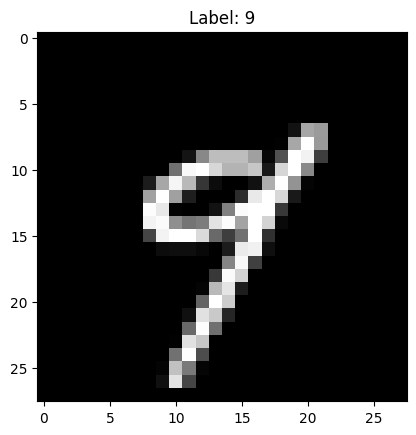

In [73]:
"""
Data Preprocessing

"""

#TODO Preprocess the AILARON dataset to a suitable format.

# #TODO Implement custome dataset for AILARON data. Should inherit from torch.utils.data.Dataset
# class AILARONDataset(torchvision.Dataset):

#     def __init__(self):
#         # Load data
#         pass

#     def __getitem__(self, index):
#         # TODO
#         pass
#     def __len__(self):
#         # TODO
#         pass 

# ailaron_train = AILARONDataset()
# dataloader = DataLoader(dataset=ailaron_train, batch_size=batch_size, shuffle=True)

# Load MNIST dataset, normalizes data and transform to tensor.
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=torchvision.transforms.ToTensor())


# # Create a subset of the MNIST dataset with the first 100 examples
# mnist_train_subset = torch.utils.data.Subset(mnist_train, range(3000))
# mnist_test_subset  = torch.utils.data.Subset(mnist_test, range(32))

# Get a random image from the dataset
image, label = mnist_train[np.random.randint(0, len(mnist_train))]

# Plot the image
plt.imshow(image[0], cmap='gray')
plt.title(f'Label: {label}')
plt.show()

# Create DataLoader
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

In [56]:
"""
Preprocessing Data
"""

# define data augmentation transforms
transform_train = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomCrop(28, padding=4),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1/255,))      # Normalize to range [-1, 1]
])

# define the transformation to be applied on the original dataset
transform_original = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1/255,))      # Normalize to range [-1, 1]
])

# load the MNIST dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)

# create the augmented and original datasets
augmented_set = [(transform_train(image), label) for image, label in mnist_train]
original_set  = [(transform_original(image), label) for image, label in mnist_train]

# create a combined dataset that interleaves the original and augmented images
combined_set = [(original_set[i][0], original_set[i][1], augmented_set[i][0]) for i in range(len(mnist_train))]

# create a data loader for the combined dataset
trainloader = torch.utils.data.DataLoader(combined_set, batch_size=batch_size, shuffle=True)

Dataset size:  60000
Batch size:  250
Number of batches:  240
Data shape:  torch.Size([1, 28, 28])
Batch 1:
Labels: tensor(1)


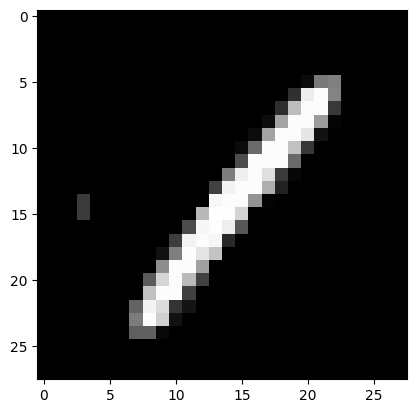

In [81]:
"""
Exploring code

"""

# for _, data in enumerate(test_loader):
#     # Get the inputs and true labels for the mini-batch and reshape
#     inputs, labels_true = data


# Get the dataset
dataset = trainloader.dataset

# Get the size of the dataset
dataset_size = len(dataset)

# Get the batch size
batch_size = trainloader.batch_size

# Get the number of batches
num_batches = len(trainloader)

# Get the shape of the data
data_shape = next(iter(trainloader))[0].shape[1:]

# Print the attributes
print("Dataset size: ", dataset_size)
print("Batch size: ", batch_size)
print("Number of batches: ", num_batches)
print("Data shape: ", data_shape)


for batch_idx, (images, labels, augmented_images) in enumerate(trainloader):
    # access the label, image and augmented image for each batch
    print(f'Batch {batch_idx+1}:')
    print('Labels:', labels[0])
    # print('Original images:', images)
    # print('Augmented images:', augmented_images)

    # Plot the image
    plt.imshow(augmented_images[0][0], cmap='gray')
    plt.show()

    # plt.imshow(augmented_images[0], cmap='gray')
    # plt.show()
    break

In [12]:
"""
Unsupervised Machine Learning Framework

"""

def train(model, train_loader: DataLoader, criterion: Callable, optimizer: torch.optim, num_epochs: int) -> None:
    """
    Trains a given model using the provided training data, optimizer and loss criterion for a given number of epochs.

    Args:
        model: Neural network model to train.
        train_loader: PyTorch data loader containing the training data.
        criterion: Loss criterion used for training the model.
        optimizer: Optimizer used to update the model's parameters.
        num_epochs: Number of epochs to train the model.

    Returns:
        None
    """
    # Loop over the epochs
    for epoch in range(num_epochs):

        # Initialize running loss for the epoch
        running_loss = 0.0
        running_acc  = 0.0

        # Loop over the mini-batches in the data loader
        for _, data in enumerate(train_loader):
        
            # Get the inputs and labels for the mini-batch and reshape
            inputs, labels = data
            inputs         = inputs.view(-1, 28*28)
        
            # Zero the parameter gradients
            optimizer.zero_grad()
        
            # Forward pass through the model
            outputs = F.softmax(model(inputs), dim=1)
        
            # Compute the loss
            loss = criterion(model, inputs, outputs)
            # Backward pass through the model and compute gradients
            loss.backward()
        
            # Update the weights
            optimizer.step()

            # Accumulate the loss for the mini-batch
            running_loss += loss.item()
            # Accumulate the accuracy for the mini-batch
            running_acc  += unsupervised_clustering_accuracy(labels, torch.argmax(outputs, dim=1))

        # Compute the average loss for the epoch and print
        print(f"Epoch {epoch+1} loss: {running_loss/len(train_loader):.4f}, ACC: {running_acc/len(train_loader):.4f}")


def unsupervised_clustering_accuracy(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    """
    Computes the unsupervised clustering accuracy between two clusterings.
    Uses the Hungarian algorithm to find the best matching between true and predicted labels.

    Args:
        y_true: true cluster labels as a 1D torch.Tensor
        y_pred: predicted cluster labels as a 1D torch.Tensor

    Returns:
        accuracy: unsupervised clustering accuracy as a float
    """
    # Create confusion matrix
    cm = confusion_matrix(y_pred, y_true)

    # Compute best matching between true and predicted labels using the Hungarian algorithm
    _, col_ind = linear_sum_assignment(-cm)

    # Reassign labels for the predicted clusters
    y_pred_reassigned = torch.tensor(col_ind)[y_pred.long()]

    # Compute accuracy as the percentage of correctly classified samples
    acc = accuracy_score(y_true, y_pred_reassigned)

    return acc


def test_classifier(model, test_loader: DataLoader) -> None:
    """
    Testing a classifier given the model and a test set.

    Args:
        model: Neural network model to train.
        test_loader: PyTorch data loader containing the test data.
    
    Returns:
        None
    """
    
    # Disable gradient computation, as we don't need it for inference
    model.eval()
    # Initialize tensors for true and predicted labels
    y_true = torch.zeros(len(test_loader.dataset))
    y_pred = torch.empty(len(test_loader.dataset))

    with torch.no_grad():
        # Iterate over the mini-batches in the data loader
        for i, data in enumerate(test_loader):
            # Get the inputs and true labels for the mini-batch and reshape
            inputs, labels_true = data
            inputs = inputs.view(-1, 28*28)

            # Forward pass through the model to get predicted labels
            labels_pred = F.softmax(model(inputs), dim=1)

            # Store predicted and true labels in tensors
            y_pred[i*len(labels_true):(i+1)*len(labels_true)] = torch.argmax(labels_pred, dim=1)
            y_true[i*len(labels_true):(i+1)*len(labels_true)] = labels_true

    # Compute unsupervised clustering accuracy score
    acc = unsupervised_clustering_accuracy(y_true, y_pred)

    print(f"\nThe unsupervised clustering accuracy score of the classifier is: {acc}")


In [13]:
"""
Unsupervised Machine Learning Algorithms

"""

#TODO Consider implementing models as classes.

from archt import NeuralNet

# Information Maximizing Self-Augmented Training
from IMSAT import regularized_information_maximization

# Invariant Information Clustering
from IIC import invariant_information_clustering


In [14]:
"""

"""

# Initialize the model, loss function, and optimizer
model     = NeuralNet()
criterion = invariant_information_clustering
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
train(model, train_loader, criterion, optimizer, num_epochs)
# Test model
test_classifier(model, test_loader)

Epoch 1 loss: -1.0324, ACC: 0.2596
Epoch 2 loss: -1.4713, ACC: 0.2673
Epoch 3 loss: -1.4714, ACC: 0.2648

The unsupervised clustering accuracy score of the classifier is: 0.2454
